NAME:**ANSHSAHU**

ROLLNO: **22CS30010**

**Introduction:**

This notebook is intended as a self-tutorial on using Principle Component Analysis (PCA) in a real-world application. This notebook uses the famous olliveti dataset and PCA to perform:
- Face Recognition
- Face Reconstruction from half-images

PCA is a mechanism of performing dimensionality reduction.  Learning is performed on a dataset with reduced features improving the processing speed and reducing feature redundancy.

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import skimage.io as skio

# Input data files need to be available in the "input" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("input"))

# Any results you write to the current directory are saved as output.

['olivetti_faces.npy', 'olivetti_faces_target.npy']


**Preparing training and test set**

The dataset is divided into training and test set. The original dataset has 10 images of 40 people = 400 images.. The function below prepares  test set by keeping one image per person in the test set  = 40 and the remaining images (360) are retained in the training set.

In [24]:
def load_train_test_set():
    faces  = np.load('input/olivetti_faces.npy')
    target = np.load('input/olivetti_faces_target.npy')
    print("Original faces.shape:"+ str(faces.shape))
    print("Original target.shape:"+ str(target.shape))

    # create a test set that takes one face for each person
    test_index = list(range(9,400,10))
    faces_test = faces[test_index]
    target_test = target[test_index]

    # preprare training set by removing items in test set
    faces_train = faces.copy()
    target_train =  target.copy()
    for i in test_index[::-1]:
        faces_train  = np.delete(faces_train,i,axis =0 )
        target_train = np.delete(target_train,i,axis =0 )

    print("faces_train.shape:" +str(faces_train.shape))
    print("target_train.shape:" +str(target_train.shape))
    print("faces_test.shape:" +str(faces_test.shape))
    print("target_test.shape:" +str(target_test.shape))
    return faces_train, target_train, faces_test, target_test


In [25]:
faces_train, target_train, faces_test, target_test = load_train_test_set()

Original faces.shape:(400, 64, 64)
Original target.shape:(400,)
faces_train.shape:(360, 64, 64)
target_train.shape:(360,)
faces_test.shape:(40, 64, 64)
target_test.shape:(40,)


**Visualize a few training images**

In [26]:
def show_sample_training_and_test_images(faces_train, faces_test):
    fig = plt.figure()
    fig.add_subplot(1, 4, 1)

    plt.imshow(faces_train[0], cmap='gray')
    fig.add_subplot(1, 4, 2)
    plt.imshow(faces_train[170], cmap='gray')
    fig.add_subplot(1, 4, 3)
    plt.imshow(faces_train[9], cmap='gray')
    fig.add_subplot(1, 4, 4)
    plt.imshow(faces_train[212], cmap='gray')
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(faces_test[0], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(faces_test[4], cmap='gray')


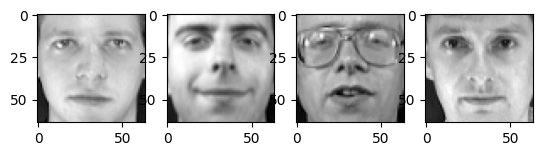

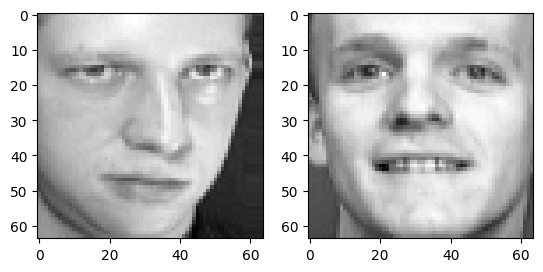

In [27]:
show_sample_training_and_test_images(faces_train, faces_test)

**Pre-process data**

Data preprocessing involves centering the images by subtracting each feature by its mean across training samples and  then dividing it by its standard deviation. This serves two purposes:
1.  The data is normalized. This avoids multiplication of arbitarily large values
2.  It makes all features unit-less. This ensures that one feature does not have value ranges different from another just due to difference in the units ( e.g. one being in cm and another meters )

In [28]:
def preprocess_data( faces_train, faces_test ):
    # flatten the imagaes from
    X_train =  np.reshape(faces_train,(faces_train.shape[0], -1 ))
    X_test =   np.reshape(faces_test, (faces_test.shape[0], -1 ))
    mu = np.mean(X_train, axis = 0 )
    std_dev = np.std(X_train, axis = 0)         # change np.mean by np.std
    std_dev_mod = np.copy(std_dev)
    std_dev_mod[std_dev == 0 ] = 1
    X_train = (X_train - mu)/std_dev_mod
    # normalize the test set with same mu and std values as training set
    X_test = (X_test - mu)/std_dev_mod
    return X_train, X_test


In [29]:
X_train, X_test = preprocess_data(faces_train, faces_test )
print("X_train.shape=" + str(X_train.shape))
print("X_test.shape="  + str(X_test.shape))


X_train.shape=(360, 4096)
X_test.shape=(40, 4096)


**Principle Component Analysis**

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. It can be derived that these principal components are nothing but  eigenvectors sorted by their eigenvalues. Eigenvectors corresponding to the highest eigenvalues  provide the most information about an image.  We can reduce dimentionality of an image by selecting eigenvectors sufficient enough to extract most of the important features and peforming orthogonal projection of the image vector on this eigenbasis. The procedure is as follows:

X = Training set of shape ( N x D ) where N = number of images , D number of pixels per image

1. Calculate covaraince matrix for training set X with images centered around the mean:
    $S = X^T X$
    
    S is a D x D matrix
2. Find the eigenvectors for X and sort  them in descending order by their eigenvalues
3. Select  K eigenvectors corresponding to the K  largest eigenvalues.



In [30]:
class PCA:
    def __init__( self, optimize = False ):
        self.__optimize = optimize

    def __calculate_covariance_matrix( self, X ):
        if self.__optimize:
            return X @ X.T
        else:
            return X.T @ X
##  sort eigenvecs and eigenvalues according to eigenvalues indecending order
    def __get_eigenvecs_sorted_by_eigenvals( self, S ):
        w, v = np.linalg.eig(S)
        sorted_index = np.argsort(w)[::-1]
        eigenvals = w[sorted_index]
        eigenvecs = v[:,sorted_index]
        return eigenvals, eigenvecs
## as above mentioned in equation 2 multiplying X.T
    def __get_eigenvec_for_original_matrix(  self, X, eigenvecs ):
        U = X.T @ eigenvecs
        return U

 ## return eigen basis and set self.__B as eigenvecs and self.__w as eigenvalues
    def fit( self, X ):
        S = self.__calculate_covariance_matrix( X )
        eigenvals,eigenvecs =   self.__get_eigenvecs_sorted_by_eigenvals( S )
        if self.__optimize :
            B = self.__get_eigenvec_for_original_matrix(X, eigenvecs )
        else:
            B = eigenvecs

        self.__B = B
        self.__w = eigenvals
        return B
     ## plot the cumulative sum of egenvalues
    def plot_eigenvals ( self ):
        c = np.cumsum ( self.__w )
        plt.plot( c )
## depending the thershold value of the variance returning eigenvecs
    def get_num_components ( self, variance_threshold):
        variance_ratio = self.__w/np.sum(self.__w)
        s = 0
        i = -1
        while s < variance_threshold and s < 1.0:
            i += 1
            s +=  variance_ratio[i]

        return i

Function to show images

In [31]:
def show_images( images, num_images_to_show ):
    fig = plt.figure()
    for i in range(1,num_images_to_show+1):
        fig.add_subplot(1,num_images_to_show,i)
        img = np.reshape( images[:,i-1], (64,64) )
        plt.imshow(img, cmap='gray')

.

** Calculating ideal value if K **

Now coming to the question of identifying the ideal value of K.   

1. Plot the cumulative sum of the eigenvalues to see how many eigenvectors capture maximum variance in the training data. If we look at the plot below we see that majority of the variance is captured by the first 50 features.

2.  We extract the eigenvectors that capture, say, 90% of the variance ( this value can be played around with ).

62


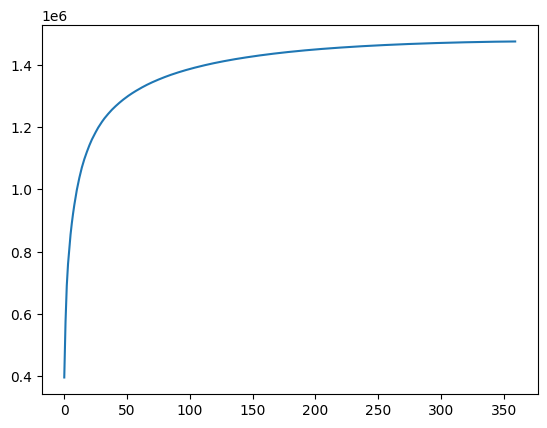

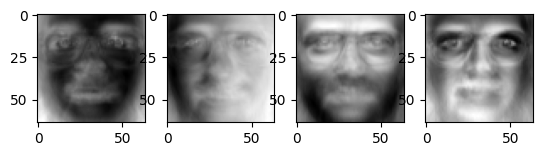

In [22]:
# Now since number of dimensions (D=4096 ) >> number of training samples (N = 360) , we calculate NXN covariance matrix instead of D X D
pca = PCA( optimize = True )
B = pca.fit(X_train)
pca.plot_eigenvals()
num_dim = pca.get_num_components(0.9)
print( num_dim )
B = B[:,:num_dim]
# show top 4 eigenfaces
show_images( B, 4 )


In [32]:
class Projection:
    def __init__( self, B ):
        self.B = B

    def reduce_dim( self, X ):                               #change B by self.B
        return  X @ self.B @ np.linalg.inv(self.B.T @ self.B)  # @ means matrix multiplication

    def reconstruct( self, X_reduced ):                   #change B by self.B

        return X_reduced @ self.B.T

    def get_projection_matrix( self ):
        P = self.B @ np.linalg.inv(self.B.T @ self.B) @ self.B.T          #change B by self.B
        return P

    def project( self , X ):
        P = self.get_projection_matrix()
        return X @ P

X_train_reduced.shape=(360, 62)


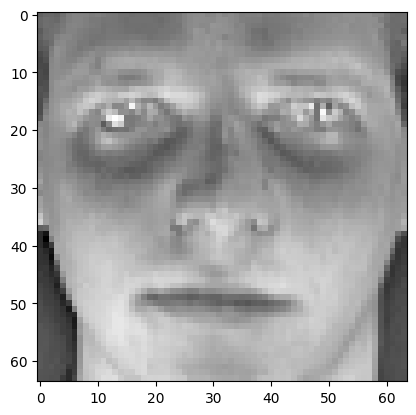

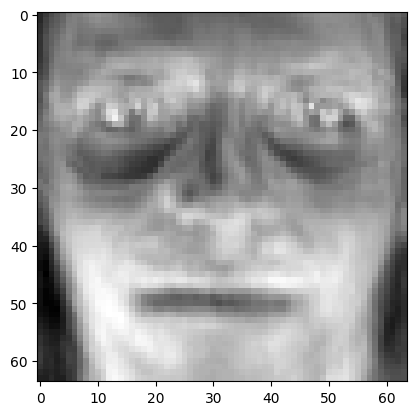

In [33]:
proj = Projection( B )
X_train_reduced = proj.reduce_dim(X_train )
print("X_train_reduced.shape="+str(X_train_reduced.shape) )
show_images(X_train.T, 1)
r_img = proj.reconstruct( X_train_reduced[0,:])
r_img = np.reshape(r_img,(4096,1))
show_images(r_img, 1)

In [34]:
X_test_reduced =proj.reduce_dim(X_test)
print("X_test_reduced.shape="+str(X_test_reduced.shape) )

X_test_reduced.shape=(40, 62)


** Image Recognition **

PCA can be used for face recognition. The idea is to :
1. Reduce dimensions of the face image to be recognized
2. Compare it with the mean image of face class class, where a class here maps to mean of images of a singleperson
3. The class to which the euclidean distance is the smallest is the class to which the person belongs i.e. is the face image of the person belonging to that class

In [35]:
class ImageClassifier:
    def __init__( self, class_count ):
        self.class_count = class_count           ## no of classes

    def __get_class_mean( self, X, target ):          ## return mean image of each class
        class_count = self.class_count
        N,D = X.shape
        mu = np.zeros((class_count,D))
        count_per_class = np.zeros(class_count)         # store number of datapoints per class
        for i in range(N):
            count_per_class[target[i]] += 1
        for i in range(class_count):
            mu[i,:] = (1/count_per_class[i]) * np.sum(X[target == i,: ], axis = 0 )  # change N by count_per_class
        return mu

## L2 norm of v1-v2
    def __dist(self, v1, v2 ):
        diff = v1-v2
        d = np.sqrt(np.dot(diff,diff))
        return d

    def fit( self,  X, target  ):
        class_count = self.class_count
        mu = self.__get_class_mean( X, target )
        self.mu = mu
# return the class by which class image belong to by finding mean image closest to test image
    def predict( self, test_img ):
        min_dist = np.inf
        min_class = -1
        for i in range( self.class_count ):
            d = self.__dist(test_img, self.mu[i,:])
            if d < min_dist:
                min_dist = d
                min_class = i

        return min_class, self.mu[min_class,:]

In [36]:
print("X_test_reduced.shape=" + str(X_test_reduced.shape))
print("X_train_reduced.shape=" + str(X_train_reduced.shape))
img_classifer = ImageClassifier(40)
img_classifer.fit(X_train_reduced,target_train )
recognized_class, mu_rec = img_classifer.predict( X_test_reduced[5,: ] )
print("recognized_class="+ str(recognized_class))

X_test_reduced.shape=(40, 62)
X_train_reduced.shape=(360, 62)
recognized_class=5



Qn 1: Calculate the performance on the Test dataset (in percentage).

Qn 2: Repeat the face regognition with extracting the eigenvectors that capture (a) 80% of the variance (b) 50% of the variance. Provide sample results and the performance accuracy.


In [38]:
# Q1 calculating performance on the test data of the model using optimize=True
performance=0
for i,image in enumerate(X_test_reduced):
    recognized_image, mu_rec = img_classifer.predict( image )
    performance += 100*(target_test[i] == recognized_image)/target_test.shape[0]

print("Accuracy =", performance, "%")

Accuracy = 92.5 %


25
X_train_reduced.shape=(360, 25)
X_test_reduced.shape=(40, 25)
X_train_reduced.shape=(360, 25)
X_test_reduced.shape=(40, 25)
recognized_class=5
Accuracy_80_var = 92.5 %


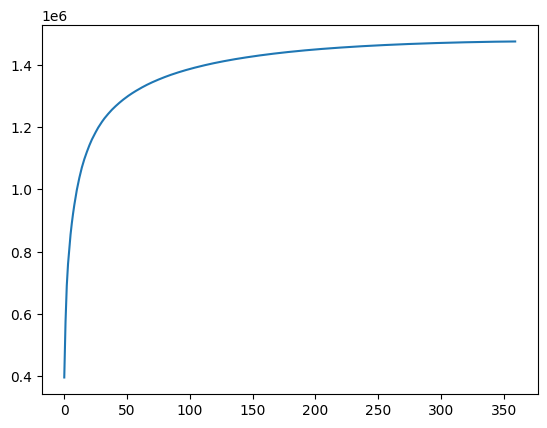

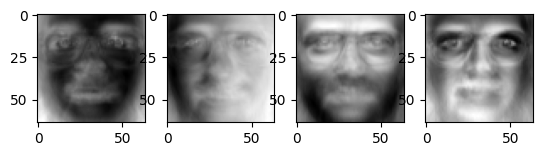

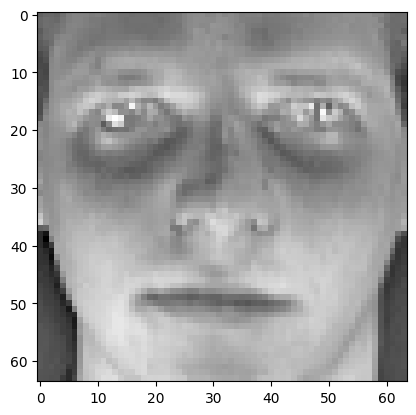

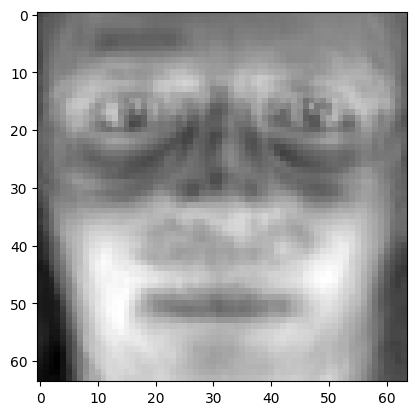

In [48]:
#Q2  PCA with 80% variance
pca_80 = PCA( optimize = True )
B_80 = pca_80.fit(X_train)
pca_80.plot_eigenvals()
num_dim_80 = pca_80.get_num_components(0.8)
print( num_dim_80 )
B_80 = B_80[:,:num_dim_80]
# show top 4 eigenfaces
show_images( B_80, 4 )

# Projection class for capturing variance 80%
proj_80 = Projection( B_80 )
X_train_reduced_80 = proj_80.reduce_dim(X_train)
print("X_train_reduced.shape="+str(X_train_reduced_80.shape))
show_images(X_train.T, 1)
r_img_80 = proj_80.reconstruct( X_train_reduced_80[0,:])
r_img_80 = np.reshape(r_img_80,(4096,1))
show_images(r_img_80, 1)

# reducing dimensionality
X_test_reduced_80 = proj_80.reduce_dim(X_test)
print("X_test_reduced.shape="+str(X_test_reduced_80.shape) )

# fitting model
print("X_train_reduced.shape=" + str(X_train_reduced_80.shape))
print("X_test_reduced.shape=" + str(X_test_reduced_80.shape))
img_classifer_80 = ImageClassifier(40)
img_classifer_80.fit(X_train_reduced_80,target_train )
recognized_class_80, mu_rec_80 = img_classifer_80.predict( X_test_reduced_80[5,: ] )
print("recognized_class="+ str(recognized_class_80))

##### testing model
accuracy_80=0
for i,image in enumerate(X_test_reduced_80):
    recognized_class_80, mu_rec_80 = img_classifer_80.predict( image )
    accuracy_80 += 100*(target_test[i] == recognized_class_80)/target_test.shape[0]
print("Accuracy_80_var =", accuracy_80, "%")

3
X_train_reduced.shape=(360, 3)
X_test_reduced.shape=(40, 3)
X_train_reduced.shape=(360, 3)
X_test_reduced.shape=(40, 3)
recognized_class=5
Accuracy_50_var = 37.5 %


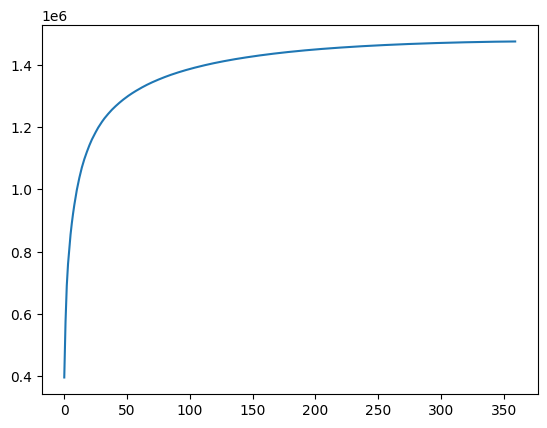

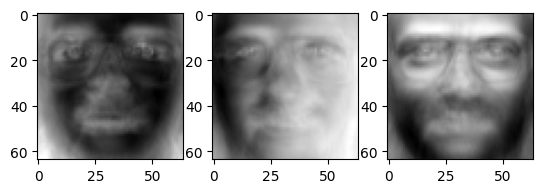

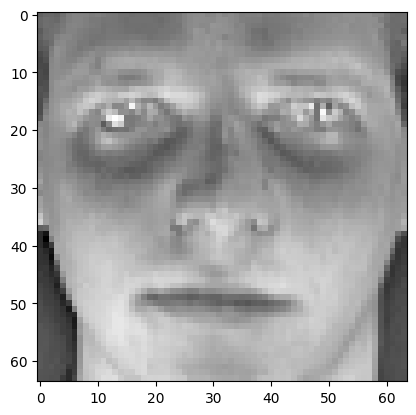

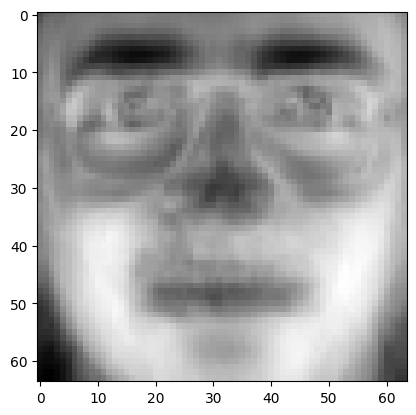

In [49]:
#Q2  PCA with 50% variance
pca_50 = PCA( optimize = True )
B_50 = pca_50.fit(X_train)
pca_50.plot_eigenvals()
num_dim_50 = pca_50.get_num_components(0.5)
print( num_dim_50 )
B_50 = B_50[:,:num_dim_50]
# show top 4 eigenfaces
show_images( B_50, 3 )

# Projection class for capturing variance 50%
proj_50 = Projection( B_50 )
X_train_reduced_50 = proj_50.reduce_dim(X_train)
print("X_train_reduced.shape="+str(X_train_reduced_50.shape))
show_images(X_train.T, 1)
r_img_50 = proj_50.reconstruct( X_train_reduced_50[0,:])
r_img_50 = np.reshape(r_img_50,(4096,1))
show_images(r_img_50, 1)

# reducing dimensionality
X_test_reduced_50 = proj_50.reduce_dim(X_test)
print("X_test_reduced.shape="+str(X_test_reduced_50.shape) )

# fitting model
print("X_train_reduced.shape=" + str(X_train_reduced_50.shape))
print("X_test_reduced.shape=" + str(X_test_reduced_50.shape))
img_classifer_50 = ImageClassifier(40)
img_classifer_50.fit(X_train_reduced_50,target_train )
recognized_class_50, mu_rec_50 = img_classifer_50.predict( X_test_reduced_50[5,: ] )
print("recognized_class="+ str(recognized_class_50))

##### testing model
accuracy_50=0
for i,image in enumerate(X_test_reduced_50):
    recognized_class_50, mu_rec_50 = img_classifer_50.predict( image )
    accuracy_50 += 100*(target_test[i] == recognized_class_50)/target_test.shape[0]
print("Accuracy_50_var =", accuracy_50, "%")

** Reconstructing incomplete image **

PCA can also be used to reconstruct an incomplete image. The idea is to project the incomplete image onto the projection matrix of the eigenbasis with K = 64 eigenvectors

In [50]:
# return the blackened half image and the original image
def get_half_image( test_image_index ):
    orig_image = np.copy(X_test[test_image_index,:])
    D, = orig_image.shape
    orig_image = np.reshape(orig_image, (1,D) )
    # blacken lower half of the face

    half_image = np.copy(orig_image)
    half_image[0, 2048: 4096] = 0
    return half_image, orig_image

In [53]:
# reconstructing half images
def reconstruct_half_images( test_indexes ):
    for i in test_indexes:
        half_image, orig_image = get_half_image(i)
        N,D = half_image.shape
        new_image = proj.project( half_image  )
        new_image[0,0:2048,] = orig_image[0, 0:2048]
        images_for_display = np.concatenate((orig_image.T, half_image.T, new_image.T), axis=1 )
        show_images(images_for_display, 3)


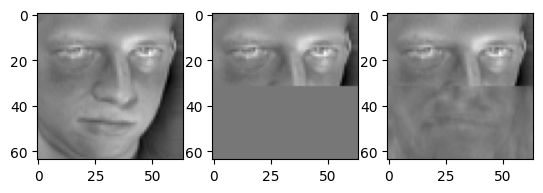

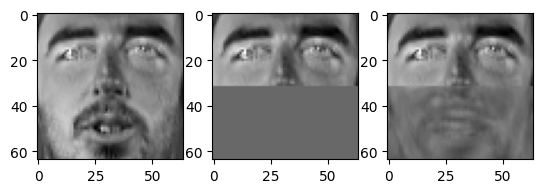

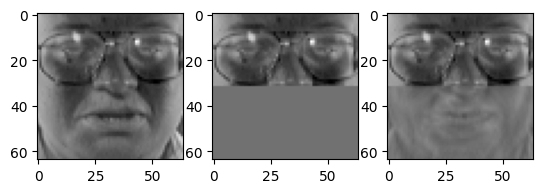

In [52]:
reconstruct_half_images([0,10,30])         # reconstructing for 3 images [0, 10, 30]

Qn 3: Repeat the face reconstruction with extracting the eigenvectors that capture (a) 80% of the variance (b) 50% of the variance. Provide sample results.

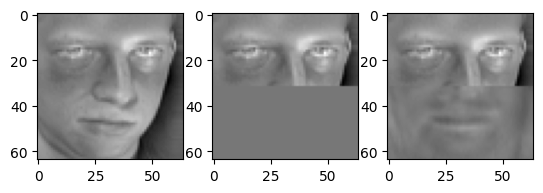

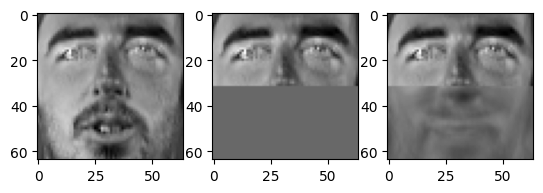

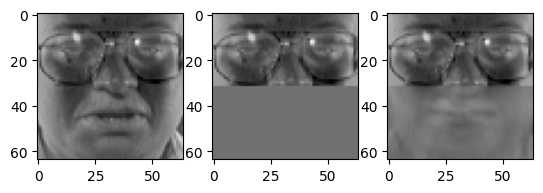

In [54]:
# Q3
# reconstruct image with PCA capturing 80% variance
def reconstruct_half_images_80( test_indexes ):
    for i in test_indexes:
        half_image, orig_image = get_half_image(i)
        N,D = half_image.shape
        new_image = proj_80.project( half_image  )
        new_image[0,0:2048,] = orig_image[0, 0:2048]
        images_for_display = np.concatenate((orig_image.T, half_image.T, new_image.T), axis=1 )
        show_images(images_for_display, 3)

reconstruct_half_images_80([0,10,30])

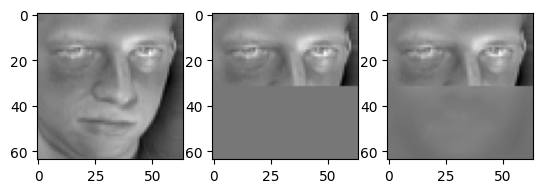

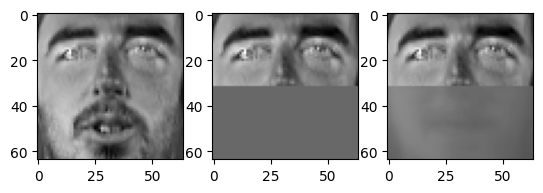

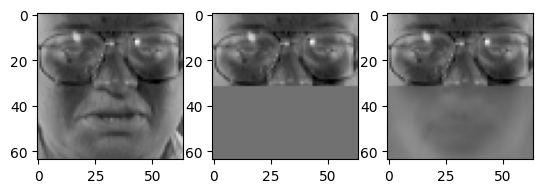

In [55]:
#Q3
#reconstruct image with PCA capturing 50% variance
def reconstruct_half_images_50( test_indexes ):
    for i in test_indexes:
        half_image, orig_image = get_half_image(i)
        N,D = half_image.shape
        new_image = proj_50.project( half_image  )
        new_image[0,0:2048,] = orig_image[0, 0:2048]
        images_for_display = np.concatenate((orig_image.T, half_image.T, new_image.T), axis=1 )
        show_images(images_for_display, 3)

reconstruct_half_images_50([0,10,30])

**Singular Value Decomposition**

To reduce the noise in data.

data.shape=(4096, 360)


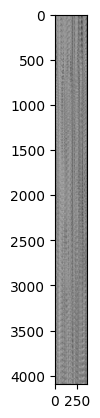

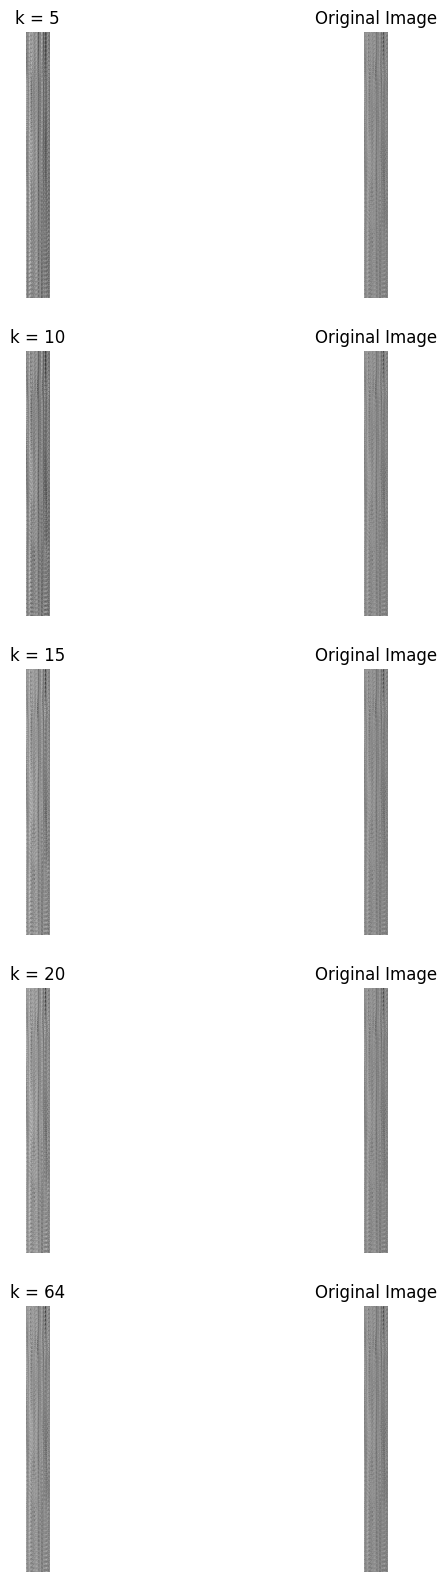

In [56]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import svd


data = X_train.T
# Adding noise
# noise = np.random.normal(0,0.1,data.shape)
# noisy_data = data + noise
# data = noisy_data

plt.imshow(data, cmap='gray')
print("data.shape=" + str(data.shape))

# calculate the SVD and plot the image
U, S, V_T = svd(data, full_matrices=False)
S = np.diag(S)
fig, ax = plt.subplots(5, 2, figsize=(8, 20))


curr_fig = 0
for r in [5, 10, 15, 20, 64]:
    data_approx = U[:, :r] @ S[0:r, :r] @ V_T[:r, :]
    ax[curr_fig][0].imshow(data_approx, cmap='gray')
    ax[curr_fig][0].set_title("k = "+str(r))
    ax[curr_fig, 0].axis('off')
    ax[curr_fig][1].set_title("Original Image")
    ax[curr_fig][1].imshow(data, cmap='gray')
    ax[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()



Plotting the image

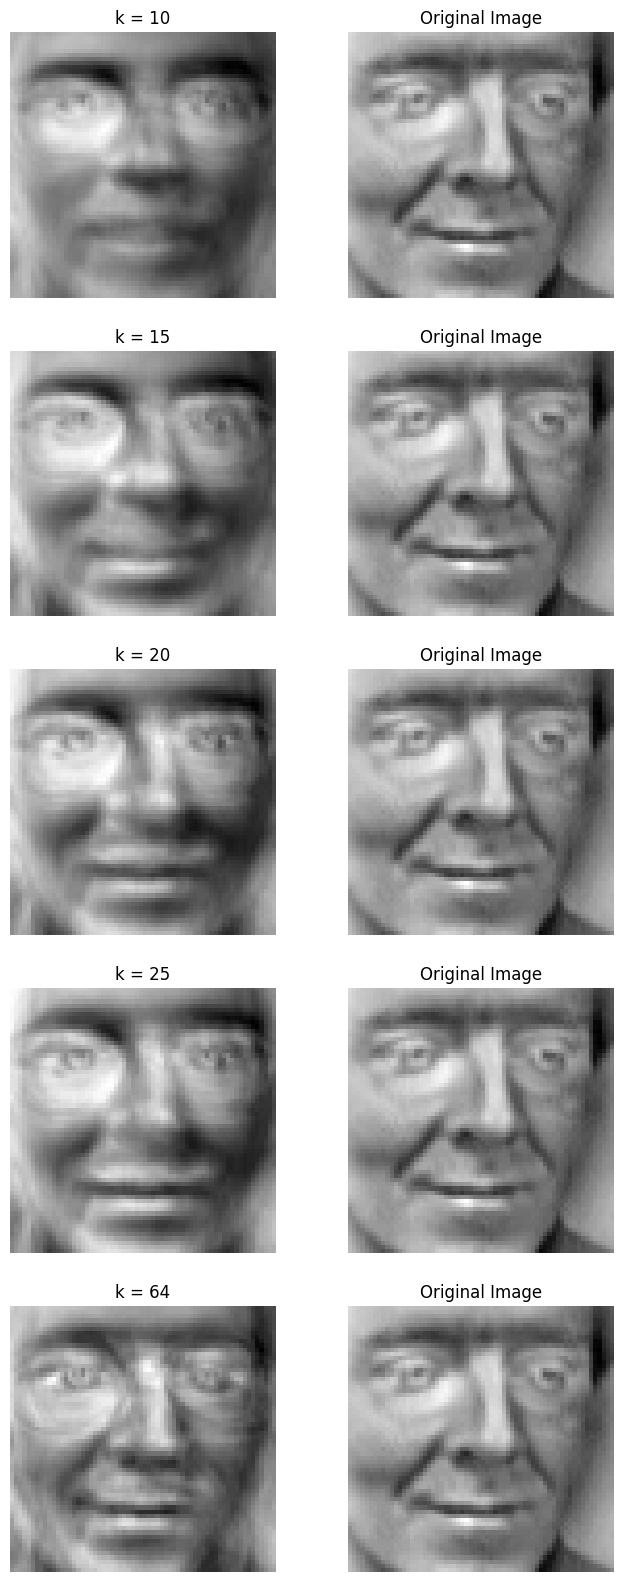

In [58]:
fig, ax = plt.subplots(5, 2, figsize=(8, 20))
img_idx = 20  # which image to plot
curr_fig = 0
for r in [10, 15, 20, 25, 64]:
    data_approx = U[:, :r] @ S[0:r, :r] @ V_T[:r, :]
    img = np.reshape( data_approx[:,img_idx], (64,64) )
    ax[curr_fig][0].imshow(img, cmap='gray')
    ax[curr_fig][0].set_title("k = "+str(r))
    ax[curr_fig, 0].axis('off')
    img_orig = np.reshape( data[:,img_idx], (64,64) )
    ax[curr_fig][1].imshow(img_orig, cmap='gray')
    ax[curr_fig][1].set_title("Original Image")
    ax[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()




Q4. Add Random noise to the data and compare these results with the no noise case above. (you may uncomment the noise addition part in the code).

Q5. Use standard deviation of noise as 0.05, 0.1, and 0.2.





data_std.shape=(4096, 360)


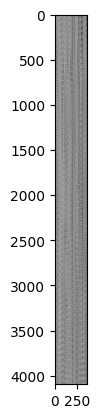

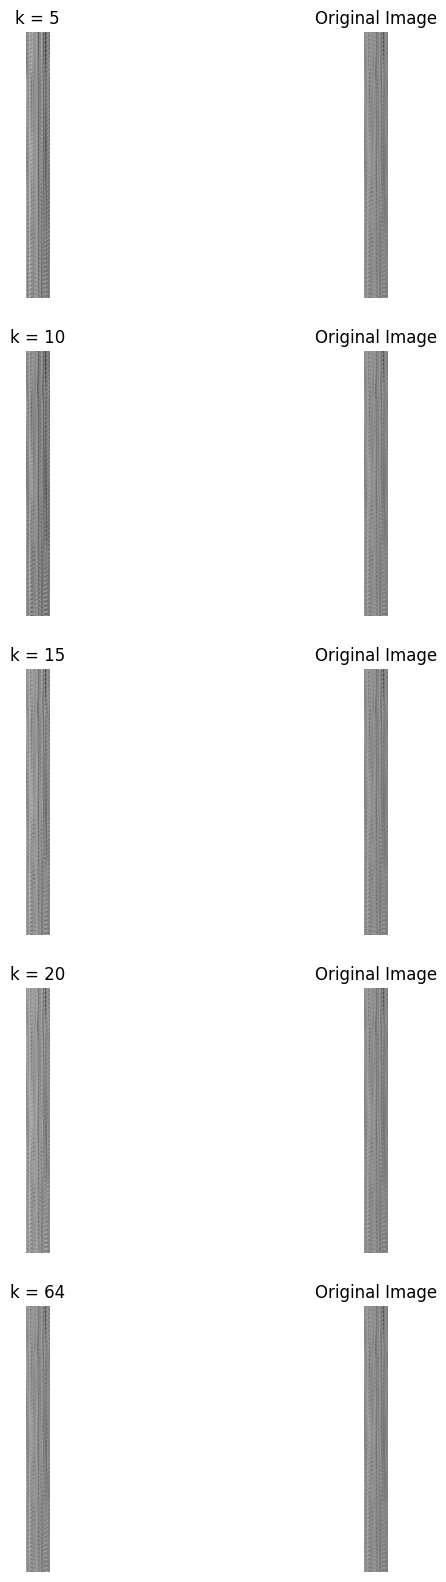

In [59]:
# Q4
# experimenting on noise with st_deviation of 0.5
data_std = X_train.T
# Add noise
noise = np.random.normal(0,0.5,data.shape)
noisy_data = data_std + noise
data_std = noisy_data

plt.imshow(data_std, cmap='gray')
print("data_std.shape=" + str(data_std.shape))

# calculate the SVD and plot the image
U_std, S_std, V_T_std = svd(data_std, full_matrices=False)
S_std = np.diag(S_std)
fig_std, ax_std = plt.subplots(5, 2, figsize=(8, 20))


curr_fig = 0
for r in [5, 10, 15, 20, 64]:
    data_approx_std_1 = U_std[:, :r] @ S_std[0:r, :r] @ V_T_std[:r, :]
    ax_std[curr_fig][0].imshow(data_approx_std_1, cmap='gray')
    ax_std[curr_fig][0].set_title("k = "+str(r))
    ax_std[curr_fig, 0].axis('off')
    ax_std[curr_fig][1].set_title("Original Image")
    ax_std[curr_fig][1].imshow(data, cmap='gray')
    ax_std[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()

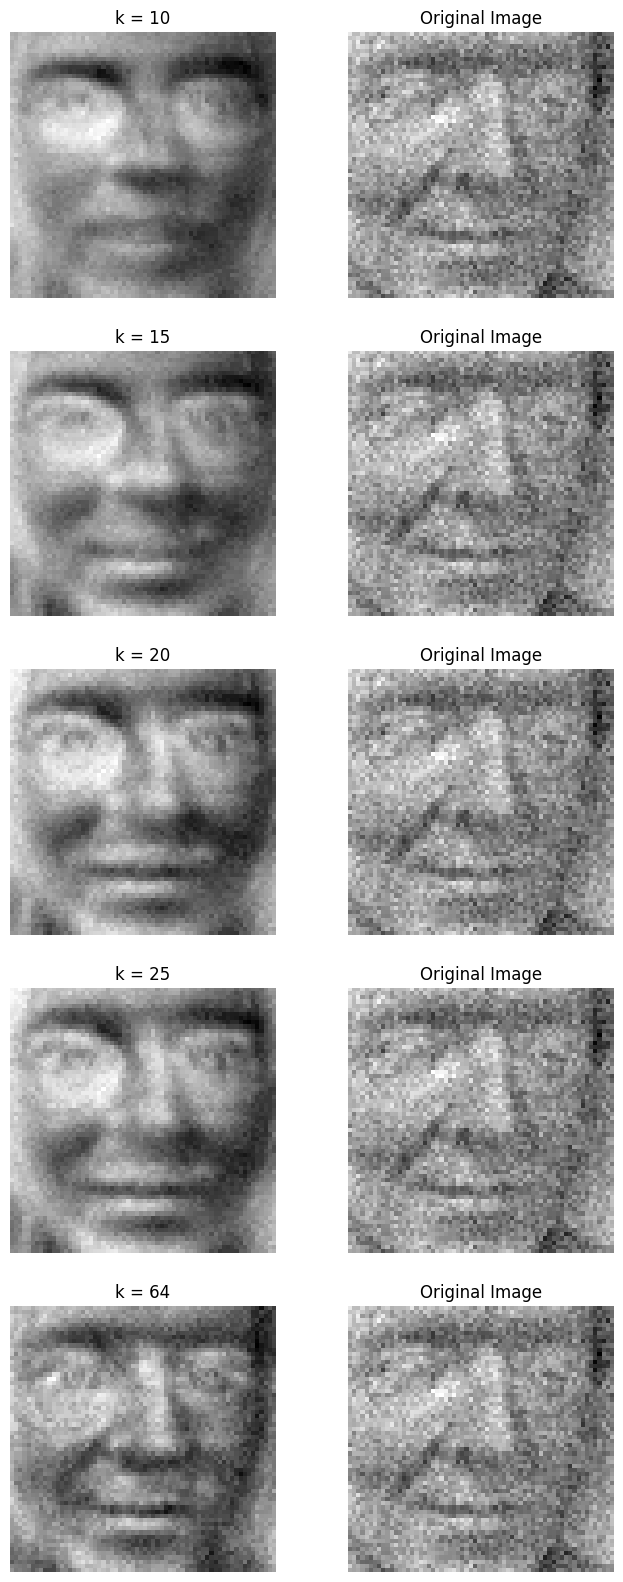

In [60]:
# performing SVD on data with noise of st_deviation 0.5
fig_std, ax_std = plt.subplots(5, 2, figsize=(8, 20))
img_idx = 20  # which image to plot
curr_fig = 0
for r in [10, 15, 20, 25, 64]:
    data_approx_std_1 = U_std[:, :r] @ S_std[0:r, :r] @ V_T_std[:r, :]
    img = np.reshape( data_approx_std_1[:,img_idx], (64,64) )
    ax_std[curr_fig][0].imshow(img, cmap='gray')
    ax_std[curr_fig][0].set_title("k = "+str(r))
    ax_std[curr_fig, 0].axis('off')
    img_orig = np.reshape( data_std[:,img_idx], (64,64) )
    ax_std[curr_fig][1].imshow(img_orig, cmap='gray')
    ax_std[curr_fig][1].set_title("Original Image")
    ax_std[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()




data_std_05.shape=(4096, 360)


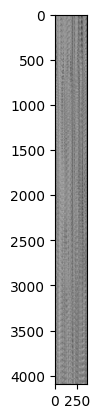

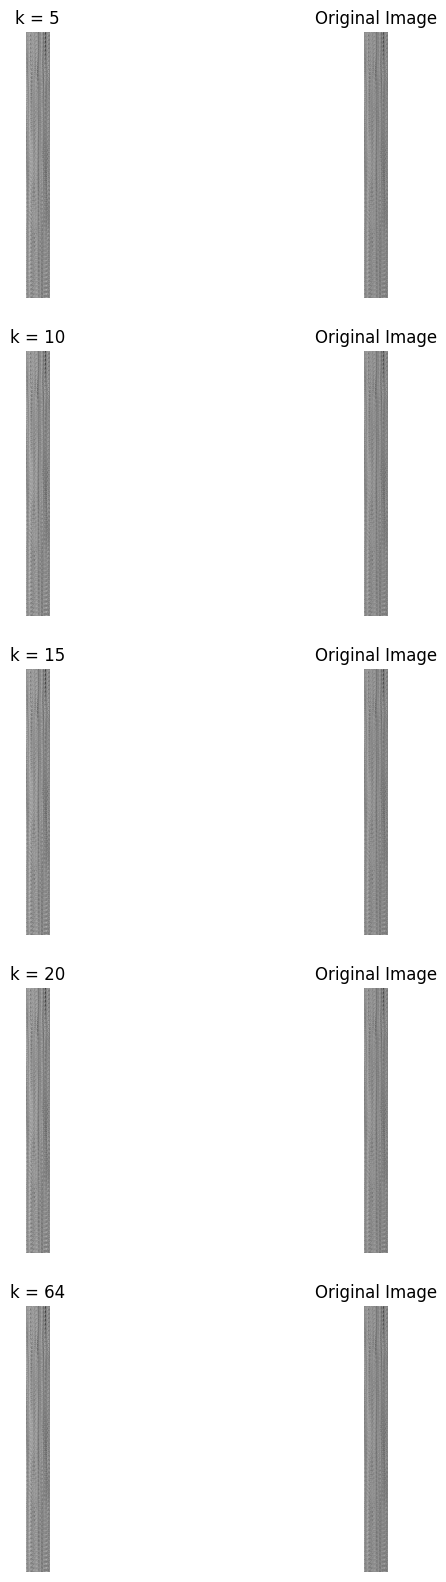

In [65]:
# Q5
# adding noise with st_deviation of 0.05
data_std_05 = X_train.T
# Adding noise
noise = np.random.normal(0,0.05,data.shape)
noisy_data = data_std_05 + noise
data_std_05 = noisy_data

plt.imshow(data_std_05, cmap='gray')
print("data_std_05.shape=" + str(data_std_05.shape))

# calculate the SVD and plot the image
U_std_05, S_std_05, V_T_std_05 = svd(data_std_05, full_matrices=False)
S_std_05 = np.diag(S_std_05)
fig_std_05, ax_std_05 = plt.subplots(5, 2, figsize=(8, 20))


curr_fig = 0
for r in [5, 10, 15, 20, 64]:
    data_approx_std_05 = U_std_05[:, :r] @ S_std_05[0:r, :r] @ V_T_std_05[:r, :]
    ax_std_05[curr_fig][0].imshow(data_approx_std_0_05, cmap='gray')
    ax_std_05[curr_fig][0].set_title("k = "+str(r))
    ax_std_05[curr_fig, 0].axis('off')
    ax_std_05[curr_fig][1].set_title("Original Image")
    ax_std_05[curr_fig][1].imshow(data, cmap='gray')
    ax_std_05[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()

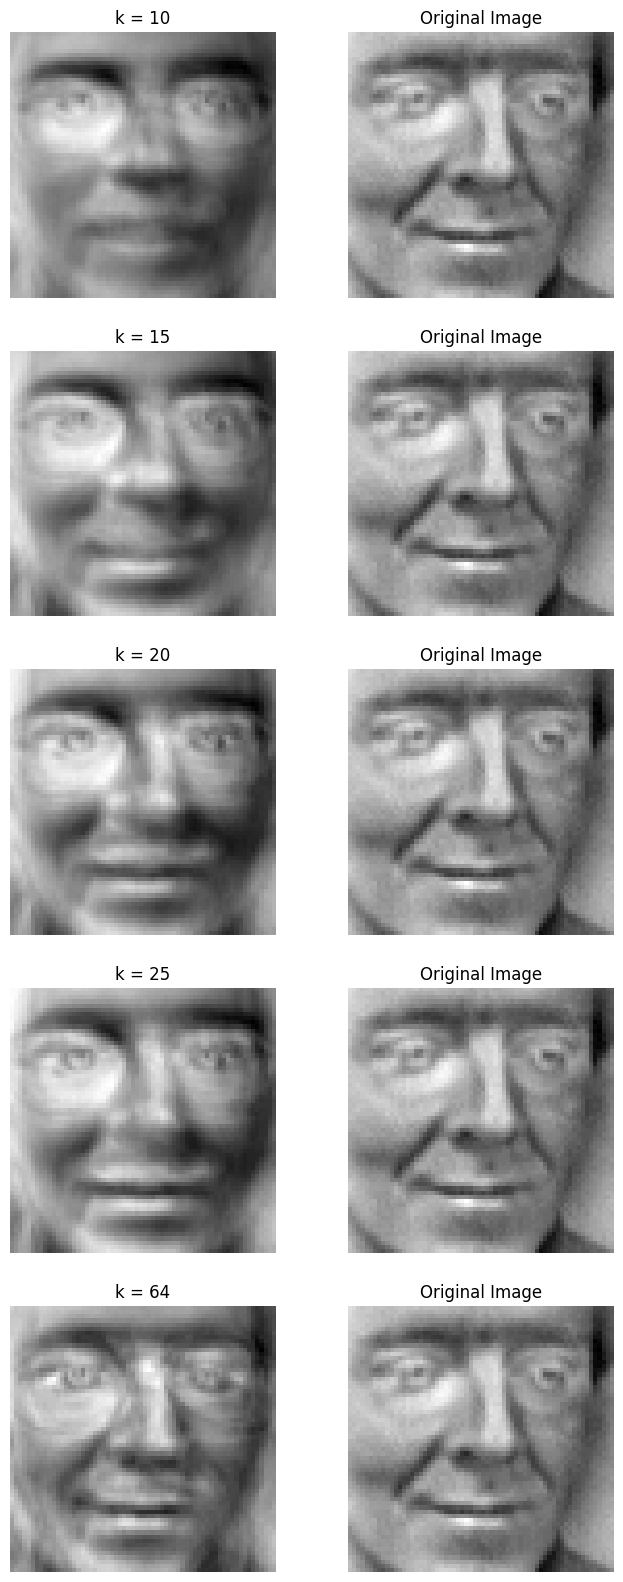

In [66]:
# performing SVD on data with noise of st_deviation 0.05
fig_std_05, ax_std_05 = plt.subplots(5, 2, figsize=(8, 20))
img_idx = 20  # which image to plot
curr_fig = 0
for r in [10, 15, 20, 25, 64]:
    data_approx_std_05 = U_std_05[:, :r] @ S_std_05[0:r, :r] @ V_T_std_05[:r, :]
    img = np.reshape( data_approx_std_05[:,img_idx], (64,64) )
    ax_std_05[curr_fig][0].imshow(img, cmap='gray')
    ax_std_05[curr_fig][0].set_title("k = "+str(r))
    ax_std_05[curr_fig, 0].axis('off')
    img_orig = np.reshape( data_std_05[:,img_idx], (64,64) )
    ax_std_05[curr_fig][1].imshow(img_orig, cmap='gray')
    ax_std_05[curr_fig][1].set_title("Original Image")
    ax_std_05[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()




data_std_1.shape=(4096, 360)


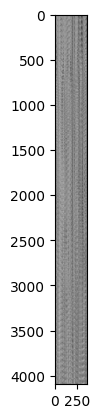

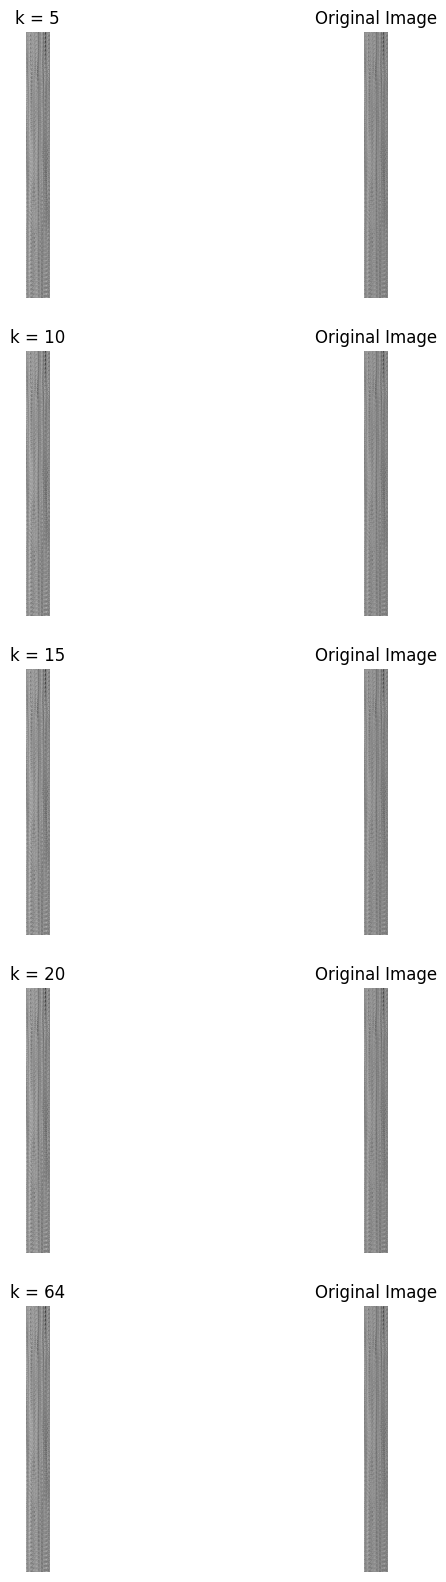

In [67]:
# Q5
# adding noise with st_deviation of 0.1
data_std_1 = X_train.T
# Adding noise
noise = np.random.normal(0,0.1,data.shape)
noisy_data = data_std_1 + noise
data_std_1 = noisy_data

plt.imshow(data_std_1, cmap='gray')
print("data_std_1.shape=" + str(data_std_1.shape))

# calculate the SVD and plot the image
U_std_1, S_std_1, V_T_std_1 = svd(data_std_1, full_matrices=False)
S_std_1 = np.diag(S_std_1)
fig_std_1, ax_std_1 = plt.subplots(5, 2, figsize=(8, 20))


curr_fig = 0
for r in [5, 10, 15, 20, 64]:
    data_approx_std_1 = U_std_1[:, :r] @ S_std_1[0:r, :r] @ V_T_std_1[:r, :]
    ax_std_1[curr_fig][0].imshow(data_approx_std_0_05, cmap='gray')
    ax_std_1[curr_fig][0].set_title("k = "+str(r))
    ax_std_1[curr_fig, 0].axis('off')
    ax_std_1[curr_fig][1].set_title("Original Image")
    ax_std_1[curr_fig][1].imshow(data, cmap='gray')
    ax_std_1[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()

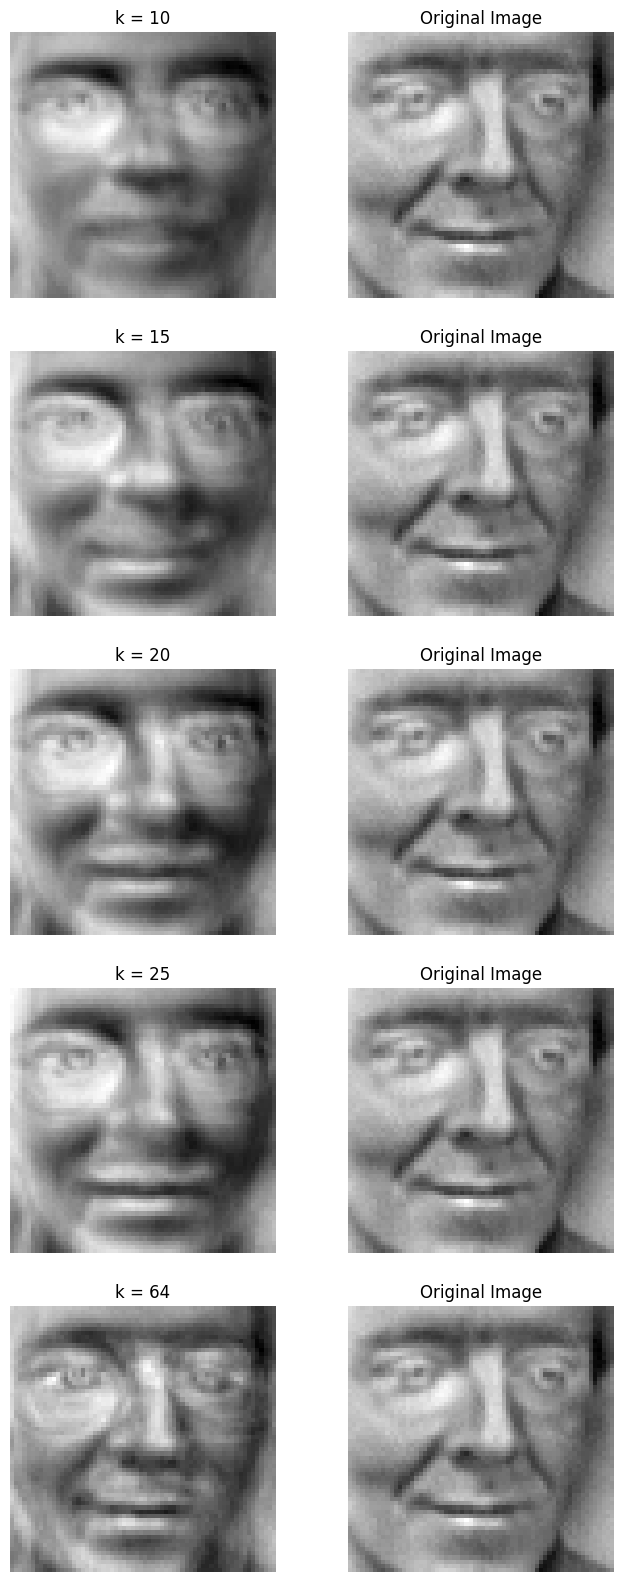

In [68]:
# performing SVD on data with noise of st_deviation 0.1
fig_std_1, ax_std_1 = plt.subplots(5, 2, figsize=(8, 20))
img_idx = 20  # which image to plot
curr_fig = 0
for r in [10, 15, 20, 25, 64]:
    data_approx_std_1 = U_std_1[:, :r] @ S_std_1[0:r, :r] @ V_T_std_1[:r, :]
    img = np.reshape( data_approx_std_1[:,img_idx], (64,64) )
    ax_std_1[curr_fig][0].imshow(img, cmap='gray')
    ax_std_1[curr_fig][0].set_title("k = "+str(r))
    ax_std_1[curr_fig, 0].axis('off')
    img_orig = np.reshape( data_std_05[:,img_idx], (64,64) )
    ax_std_1[curr_fig][1].imshow(img_orig, cmap='gray')
    ax_std_1[curr_fig][1].set_title("Original Image")
    ax_std_1[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()




data_std_2.shape=(4096, 360)


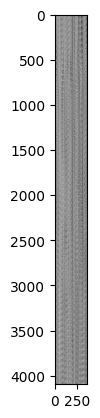

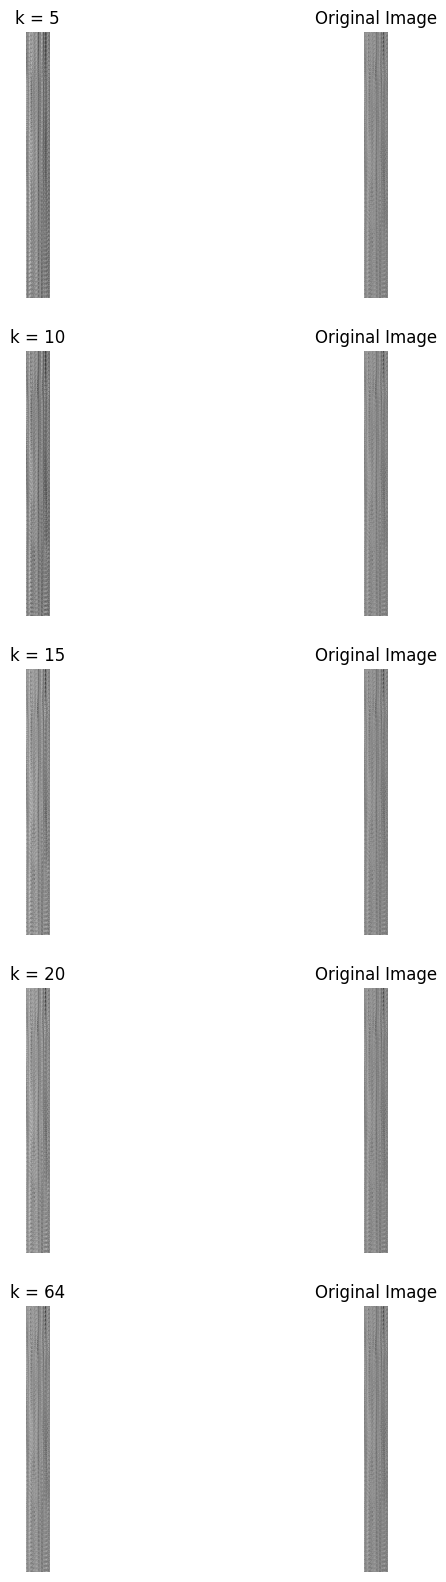

In [69]:
# Q5
# adding noise with st_deviation of 0.2
data_std_2 = X_train.T
# Adding noise
noise = np.random.normal(0,0.2,data.shape)
noisy_data = data_std_2 + noise
data_std_2 = noisy_data

plt.imshow(data_std_2, cmap='gray')
print("data_std_2.shape=" + str(data_std_2.shape))

# calculate the SVD and plot the image
U_std_2, S_std_2, V_T_std_2 = svd(data_std_2, full_matrices=False)
S_std_2 = np.diag(S_std_2)
fig_std_2, ax_std_2 = plt.subplots(5, 2, figsize=(8, 20))


curr_fig = 0
for r in [5, 10, 15, 20, 64]:
    data_approx_std_2 = U_std_2[:, :r] @ S_std_2[0:r, :r] @ V_T_std_2[:r, :]
    ax_std_2[curr_fig][0].imshow(data_approx_std_2, cmap='gray')
    ax_std_2[curr_fig][0].set_title("k = "+str(r))
    ax_std_2[curr_fig, 0].axis('off')
    ax_std_2[curr_fig][1].set_title("Original Image")
    ax_std_2[curr_fig][1].imshow(data, cmap='gray')
    ax_std_2[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()

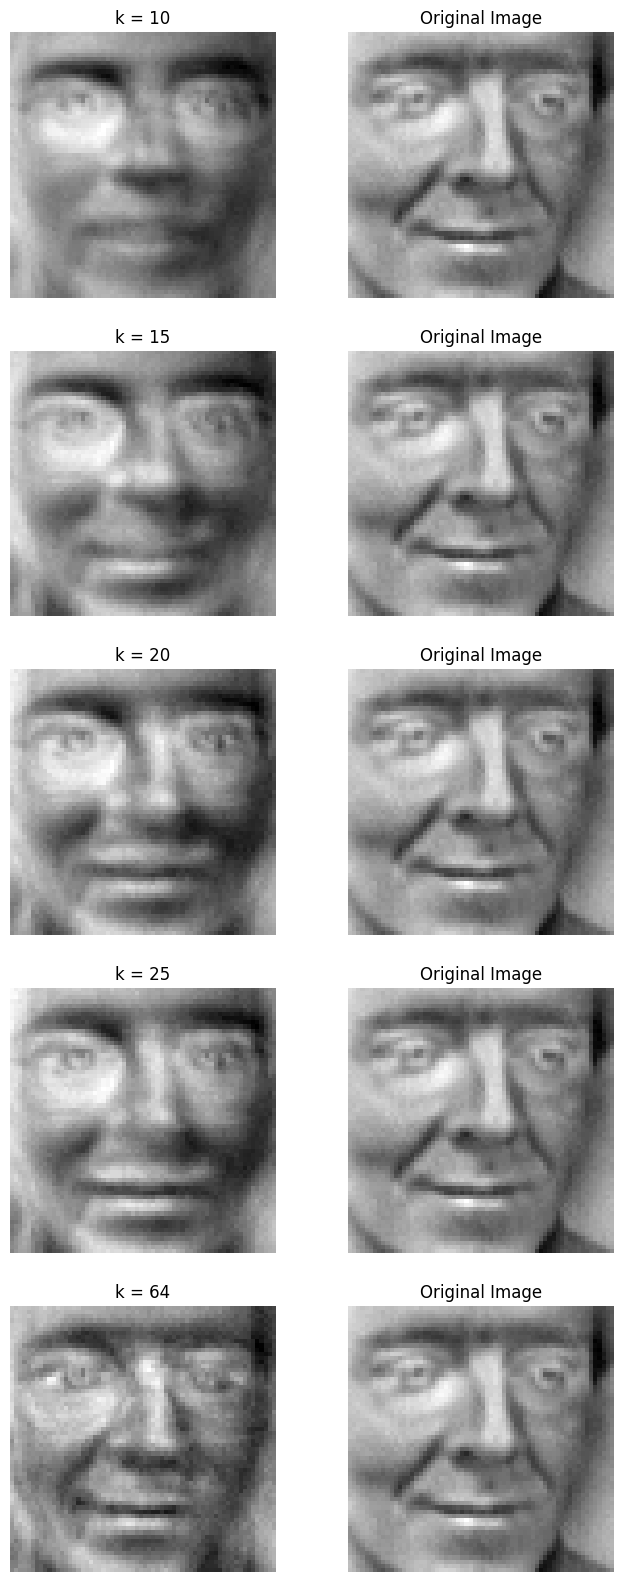

In [70]:
# performing SVD on data with noise of st_deviation 0.2
fig_std_2, ax_std_2 = plt.subplots(5, 2, figsize=(8, 20))
img_idx = 20  # which image to plot
curr_fig = 0
for r in [10, 15, 20, 25, 64]:
    data_approx_std_2 = U_std_2[:, :r] @ S_std_2[0:r, :r] @ V_T_std_2[:r, :]
    img = np.reshape( data_approx_std_2[:,img_idx], (64,64) )
    ax_std_2[curr_fig][0].imshow(img, cmap='gray')
    ax_std_2[curr_fig][0].set_title("k = "+str(r))
    ax_std_2[curr_fig, 0].axis('off')
    img_orig = np.reshape( data_std_05[:,img_idx], (64,64) )
    ax_std_2[curr_fig][1].imshow(img_orig, cmap='gray')
    ax_std_2[curr_fig][1].set_title("Original Image")
    ax_std_2[curr_fig, 1].axis('off')
    curr_fig += 1
plt.show()


